# Creating a Topic Model Using Mallet and Gensim

Because finding meaningful topics is difficult using metrics like perplexity and coherence alone, I'll be using this notebook to manually tweak my model creation and then visually inspecting results to ensure that they make sense. A significant amount of the code for this notebook is based on a [gensim topic mining tutorial](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/) by [Selva Prabhakaran](https://www.machinelearningplus.com/author/selva86/).

In [1]:
import os
import re
import lxml # Included to speed up processing
import cchardet # Included to speed up processing
import numpy as np
import pandas as pd
import metapy
from pprint import pprint
from collections import OrderedDict
import gensim
import gensim.corpora as corpora
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation, remove_stopwords, strip_tags, strip_numeric, strip_non_alphanum
from gensim.models import CoherenceModel, Phrases
from bs4 import BeautifulSoup
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from ranker import load_ranker

# Creating a Corpus

The first step is to create a corpus to use for modeling.

In [48]:
top_directory = "../compiled_bios"
filters_path = "../"
def get_array_from_file(filters_path):
    array_file = open(filters_path, 'r')
    array = re.split(' |\n|\t', array_file.read().lower())
    array_file.close()
    array = [arr.replace('\r', '') for arr in array if len(arr.replace('\r', '')) > 0]
    return set(array)

def iter_documents(top_directory, filters):
    custom_filter = [lambda x: x.lower(), strip_punctuation, remove_stopwords, strip_tags, strip_non_alphanum, strip_numeric]
    """Iterate over all documents, yielding a document (=list of utf8 tokens) at a time."""
    for root, dirs, files in os.walk(top_directory):
        for file in filter(lambda file: file.endswith('.txt'), files):
            document = open(os.path.join(root, file)).read().lower() # read the entire document, as one big string
            soup = BeautifulSoup(document, "lxml")
            document = soup.get_text(separator='\n').split(' ')
            document = preprocess_string(' '.join(document), custom_filter)
            document = [word for word in document if word not in filters]
            document = [word for word in document if len(word) > 4]
            
            yield document 

class CorpusContainer(object):
    def __init__(self, top_dir, filters_path):
        self.top_dir = top_dir
        filter_set = self.__construct_filter_set(filters_path) 
        self.docs = list(iter_documents(top_dir, filter_set))
        self.bigram = Phrases(self.docs, min_count=2)
        self.trigram = Phrases(self.bigram[self.docs], min_count=2)
        self.__append_bigrams_and_trigrams()
        self.dictionary = gensim.corpora.Dictionary(self.docs)
        self.dictionary.filter_extremes(no_below=10, no_above=.5, keep_n=30000) # check API docs for pruning params
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.docs]
        
    def __iter__(self):
        for tokens in iter_documents(self.top_dir, self.filters):
            yield self.dictionary.doc2bow(tokens)
            
    def __len__(self):
        return len(self.docs)
    
    def __construct_filter_set(self, filters_path):
        filters = get_array_from_file(filters_path + 'names.txt')
        filters.update(get_array_from_file(filters_path + 'unis'))
        filters.update(get_array_from_file(filters_path + 'urls'))
        filters.update(get_array_from_file(filters_path + 'emails'))
        #filters.update(get_array_from_file(filters_path + 'depts'))
        filters.update(get_array_from_file(filters_path + 'location'))
        #filters.update(get_array_from_file(filters_path + 'unwanted_words.txt'))
        return filters
    
    
    def __append_bigrams_and_trigrams(self):
        for idx in range(len(self.docs)):
            bigrams = [bigram for bigram in self.bigram[self.docs[idx]] if bigram.count('_') == 1]
            trigrams = [trigram for trigram in self.trigram[self.bigram[self.docs[idx]]] if trigram.count('_') == 2]
        
            for token in bigrams:
                split_tokens = list(OrderedDict.fromkeys(token.split('_')))
                for tok in split_tokens:
                    self.docs[idx] = filter(lambda word: word != tok, self.docs[idx])
                self.docs[idx].append('_'.join(split_tokens))
                
            for token in trigrams:
                split_tokens = list(OrderedDict.fromkeys(token.split('_')))
                for tok in split_tokens:
                    self.docs[idx] = filter(lambda word: word != tok, self.docs[idx])
                self.docs[idx].append('_'.join(split_tokens))
            
    
        

corpus_container = CorpusContainer(top_directory, filters_path) # create a dictionary

# Creating Topic Model

I've chosen mallet because it creates considerably better topics than gensim's LDA algorithm.

In [49]:
mallet_path = './mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(
    mallet_path, 
    corpus=corpus_container.corpus, 
    num_topics=10, 
    id2word=corpus_container.dictionary)
pprint(ldamallet.show_topics(formatted=False))


[(0,
  [(u'programs', 0.008495441140661779),
   (u'academics', 0.005789886637266308),
   (u'issue_pages', 0.005194664646519304),
   (u'function_return', 0.004883525878628825),
   (u'corporate_governance', 0.004748248153459051),
   (u'foundation', 0.004694137063391142),
   (u'access', 0.00465355374584021),
   (u'graduate_students', 0.004410053840534617),
   (u'postgraduate_degrees', 0.003814831849787614),
   (u'social_innovation', 0.003693081897134818)]),
 (1,
  [(u'right_arrow', 0.027391339149923956),
   (u'graduate_students', 0.019723044905146883),
   (u'phone', 0.010918114143920596),
   (u'people_directory', 0.007812374929960778),
   (u'admissions', 0.006723765308572801),
   (u'facebook_twitter', 0.006419594973184984),
   (u'giving', 0.0064035860081645725),
   (u'interests', 0.0064035860081645725),
   (u'facts_figures', 0.006211478427919635),
   (u'information', 0.005330985351797006)]),
 (2,
  [(u'machine_learning', 0.022755809956719067),
   (u'artificial_intelligence', 0.01120955126

In [50]:
coherence_model_lda = CoherenceModel(model=ldamallet, texts=corpus_container.docs, dictionary=corpus_container.dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

0.5320017529893444

In [51]:
def topic_number_evaluator(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_vals = []
    models = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        models.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_vals.append(coherence_model.get_coherence())
        
    return models, coherence_vals

In [52]:
models, coherence_vals= topic_number_evaluator(corpus_container.dictionary, corpus_container.corpus, corpus_container.docs, start=10, limit=100, step=5)

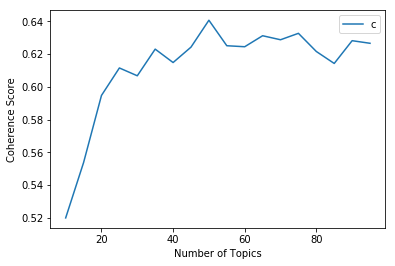

In [54]:
limit = 100
start = 10
step = 5
x = range(start, limit, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_vals"), loc='best')
plt.show()

In [55]:
for m, cv in zip(x, coherence_vals):
    print("Num topics = ", m, " has coherence value of", round(cv, 4))

('Num topics = ', 10, ' has coherence value of', 0.5199)
('Num topics = ', 15, ' has coherence value of', 0.5537)
('Num topics = ', 20, ' has coherence value of', 0.5947)
('Num topics = ', 25, ' has coherence value of', 0.6115)
('Num topics = ', 30, ' has coherence value of', 0.6067)
('Num topics = ', 35, ' has coherence value of', 0.623)
('Num topics = ', 40, ' has coherence value of', 0.6148)
('Num topics = ', 45, ' has coherence value of', 0.6242)
('Num topics = ', 50, ' has coherence value of', 0.6406)
('Num topics = ', 55, ' has coherence value of', 0.6251)
('Num topics = ', 60, ' has coherence value of', 0.6245)
('Num topics = ', 65, ' has coherence value of', 0.6312)
('Num topics = ', 70, ' has coherence value of', 0.6287)
('Num topics = ', 75, ' has coherence value of', 0.6326)
('Num topics = ', 80, ' has coherence value of', 0.6216)
('Num topics = ', 85, ' has coherence value of', 0.6142)
('Num topics = ', 90, ' has coherence value of', 0.6281)
('Num topics = ', 95, ' has cohe

In [161]:
optimal_model = models[11]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(23,
  u'0.014*"chemical_biomolecular" + 0.013*"quick_links" + 0.010*"featured_videos" + 0.010*"halluniversity_californiaberkeley" + 0.010*"navigation_chemistry" + 0.009*"awards_honors" + 0.008*"rights_reserved" + 0.008*"group" + 0.007*"chemistry_chemical" + 0.007*"impact"'),
 (45,
  u'0.021*"aerospace_sciences" + 0.012*"closed_level" + 0.011*"dynamic" + 0.010*"federal_investigators" + 0.010*"acoustical_society" + 0.009*"proceedings_turbo" + 0.009*"active_level" + 0.009*"society_mechanical" + 0.009*"study" + 0.009*"energy"'),
 (57,
  u'0.023*"video" + 0.017*"interactive" + 0.016*"human_interaction" + 0.015*"visualization" + 0.014*"visual" + 0.014*"virtual_reality" + 0.013*"transactions_graphics" + 0.009*"based" + 0.009*"media" + 0.009*"information"'),
 (15,
  u'0.011*"function_return" + 0.009*"postgraduate_degrees" + 0.008*"details_classname" + 0.008*"details_summary" + 0.008*"function_details" + 0.008*"summary_display" + 0.007*"taught_courses" + 0.007*"foundation" + 0.007*"access" + 

In [163]:
topic_num = max(optimal_model[corpus_container.corpus[0]], key = lambda x: x[1])[0]
optimal_model.show_topic(topic_num)

[(u'operating_systems', 0.02296253835519439),
 (u'distributed_systems', 0.015679266277775904),
 (u'management', 0.014465387598206158),
 (u'performance_computing', 0.014397949893785615),
 (u'distributed_computing', 0.013386384327477492),
 (u'cloud_computing', 0.011869035978015308),
 (u'large_scale', 0.009576154027716896),
 (u'embedded_systems', 0.007687898303941734),
 (u'proceedings_symposium', 0.007553022895100651),
 (u'storage', 0.007182115520787673)]

In [164]:
topic_num = max(optimal_model[corpus_container.dictionary.doc2bow(['topic', 'mining'])], key = lambda x: x[1])[0]
optimal_model.show_topic(topic_num)

[(u'natural_language', 0.027331308791941337),
 (u'analysis', 0.015332197614991482),
 (u'information_retrieval', 0.014554477446115103),
 (u'knowledge_discovery', 0.013924894452262795),
 (u'social_media', 0.011962076883193838),
 (u'mining', 0.011184356714317459),
 (u'artificial_intelligence', 0.011073253833049404),
 (u'computational_linguistics', 0.009740019257832752),
 (u'social_networks', 0.008999333382712391),
 (u'semantic', 0.00788830457003185)]

# Saving the Model

The topics mostly make sense to me, so I'll save the model so that I can load it for inference. I'll probably continue tweaking this until the project is due.

In [166]:
optimal_model = gensim.models.wrappers.LdaMallet(
    mallet_path, 
    corpus=corpus_container.corpus, 
    num_topics=65, 
    id2word=corpus_container.dictionary,
    prefix='./model_files/'
)

In [167]:
optimal_model.save('lda_mallet_model')

In [168]:
model = gensim.utils.SaveLoad.load('lda_mallet_model') # Make sure the model saved properly

In [169]:
topic_num = max(model[corpus_container.dictionary.doc2bow(['topic', 'mining'])], key = lambda x: x[1])[0]
model.show_topic(topic_num)

[(u'machine_learning', 0.0884036393713813),
 (u'artificial_intelligence', 0.04304383788254756),
 (u'natural_language', 0.024416873449131515),
 (u'information_retrieval', 0.01293631100082713),
 (u'conference_artificial', 0.012539288668320927),
 (u'knowledge_discovery', 0.012473118279569893),
 (u'computational_linguistics', 0.00870140612076096),
 (u'social_media', 0.008635235732009926),
 (u'large_scale', 0.00846980976013234),
 (u'world', 0.007808105872622002)]

# Saving the Dictionary

Because I need to dictionary for inference, I'll go ahead and save it too.

In [170]:
corpus_container.dictionary.save('corpus_dictionary')

In [171]:
corpora.MmCorpus.serialize('lda_corpus', corpus_container.corpus)